references
1. https://github.com/ultralytics/ultralytics/issues/1693
2. https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/3
3. https://pytorch.org/docs/master/autograd.html?highlight=grad#torch.autograd.grad
4. https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/


In [1]:
from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

In [2]:
# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args.yaml')

Ultralytics YOLOv8.0.86 🚀 Python-3.9.16 torch-2.0.0 CPU
yolo/engine/trainer: task=detect, mode=predict, model=../model_results/train/weights/best.pt, data=../detection_data.yaml, epochs=1, patience=50, batch=1, imgsz=128, save=False, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=1, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, sim

In [3]:
trainer.setup_model()


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track

In [4]:
trainer.set_model_attributes()

## Version using image resizing (without dataloader)

(28, 112, 3)


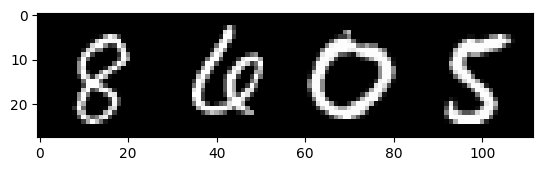

In [5]:
org_img = cv2.imread('../data/YOLO_short/images/0.png')
print(org_img.shape)
plt.imshow(org_img)
plt.show()

In [13]:
# so that the channel comes first (xdim, ydim, channel) -> (channel, xdim, ydim); threw an error when order different
# error: expected input[1, 128, 128, 3] to have 3 channels, but got 128 channels instead
input_img = np.moveaxis(org_img, -1, 0)
input_img.shape

input_img = np.expand_dims(input_img, axis=0) # to add (1, )
input_img.shape

(1, 3, 28, 112)

In [14]:
tensor_img = torch.tensor(np.array(input_img, dtype='float32'), requires_grad=True)
tensor_img.shape

torch.Size([1, 3, 28, 112])

In [16]:
tensor_img_resized = resize_right.resize(tensor_img, out_shape=(1,3,128,128))
tensor_img_resized.shape

torch.Size([1, 3, 128, 128])

In [18]:
# definining batch with true label and bboxes to calculate the loss

batch = {'ori_shape': ((28, 112),),
 'ratio_pad': None,
 'im_file': None,
 'img': None,
 'cls': torch.tensor([[8.],
         [6.],
         [0.],
         [5.]]),
 'bboxes': torch.tensor([[0.1250, 0.5000, 0.2250, 0.2250],
         [0.3750, 0.5000, 0.2250, 0.2250],
         [0.6250, 0.5000, 0.2250, 0.2250],
         [0.8750, 0.5000, 0.2250, 0.2250]]),
 'batch_idx': torch.tensor([0., 0., 0., 0.])}

# resized image we feed to the model
batch['img'] = tensor_img_resized

In [19]:
# this is where backpropagation happens
a = trainer.model(tensor_img_resized)
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, batch)
loss.backward()

In [20]:
print(tensor_img.grad.shape)
tensor_img.grad

torch.Size([1, 3, 28, 112])


tensor([[[[ 9.2492e-04,  1.5137e-03,  1.3247e-03,  ..., -5.8940e-05, -2.7097e-04, -2.1566e-04],
          [ 3.5895e-03,  3.8699e-03,  2.9743e-03,  ...,  3.5412e-04,  1.8898e-04,  1.2386e-04],
          [ 1.3349e-03,  1.1913e-03,  1.0731e-03,  ..., -3.5590e-04, -4.4534e-04, -3.2851e-04],
          ...,
          [-1.8550e-03, -1.3704e-03, -3.8579e-04,  ..., -2.0221e-03, -3.2223e-03, -2.2100e-03],
          [-1.5323e-03, -4.9775e-04,  5.4932e-04,  ..., -2.3425e-04, -1.8850e-03, -1.5106e-03],
          [ 1.2628e-03,  1.5794e-03,  1.5015e-03,  ...,  1.8404e-03,  9.0323e-04,  5.8194e-04]],

         [[-1.7921e-03, -7.1454e-04, -2.1065e-04,  ...,  3.4854e-05,  1.1420e-04,  1.2718e-04],
          [-5.8348e-03, -3.2799e-03, -1.5298e-03,  ..., -1.8148e-04, -9.5691e-05, -3.4160e-05],
          [-2.0760e-03, -1.3825e-03, -8.0358e-04,  ..., -4.6732e-05,  1.8254e-04,  1.5429e-04],
          ...,
          [ 2.6248e-03,  1.3782e-03,  2.4971e-04,  ...,  5.7348e-04,  6.3507e-04,  1.0064e-03],
        

## one using loader

In [21]:
loader = create_dataloader('../data/YOLO_short/images', imgsz=128,
                           batch_size=1,
                           stride=1)

Scanning ../data/YOLO_short/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]


In [22]:
batch = next(iter(loader[0]))
batch['img'].shape

torch.Size([1, 3, 128, 128])

In [23]:
# check if the batch['img'] is a leaf node; if it is .backward() accumulates grad
batch['img']=batch['img'].float()
print(batch['img'].is_leaf)
print(batch['img'].requires_grad)
batch['img'].requires_grad=True # additional argument to get the gradient of the input

True
False


In [24]:
batch['img'].shape

torch.Size([1, 3, 128, 128])

In [25]:
# batch variable set from the loader has cls (true label of the images)
# it reads the data from data=../detection_data.yaml, in args.yaml when calling the trainer
batch

{'ori_shape': ((28, 112),),
 'ratio_pad': (((1.1428571428571428, 1.1428571428571428), (0.0, 48.0)),),
 'im_file': ('../data/YOLO_short/images/0.png',),
 'img': tensor([[[[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           ...,
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.]],
 
          [[114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..., 114., 114., 114.],
           [114., 114., 114.,  ..

In [26]:
# this is where backpropagation happens
a = trainer.model(batch['img'])
loss_fn = Loss(trainer.model)
loss, _ = loss_fn(a, batch)
loss.backward()

In [27]:
(batch['img'].grad).shape # this version gives the gradient w.r.t. resized input

torch.Size([1, 3, 128, 128])

In [28]:
batch['img'].grad # checked that the gradient w.r.t. input is deterministic

tensor([[[[ 3.0678e-05, -1.8723e-04, -5.6495e-04,  ...,  5.5701e-03,  7.3125e-03,  5.1939e-03],
          [ 8.4913e-04,  4.8150e-05, -1.2031e-03,  ...,  6.1341e-03,  8.8653e-03,  5.9796e-03],
          [ 2.5488e-03,  7.3475e-04, -2.4057e-03,  ...,  5.9311e-03,  5.5987e-03,  3.4876e-03],
          ...,
          [-2.4228e-03, -9.3500e-04, -3.8466e-04,  ..., -5.1462e-03, -6.4833e-03, -4.9381e-03],
          [-4.3758e-03, -4.8144e-03, -3.6602e-03,  ..., -2.9989e-03, -2.8014e-03, -1.9724e-03],
          [-3.9081e-03, -4.6390e-03, -3.2471e-03,  ..., -2.5209e-03, -2.4373e-03, -1.9301e-03]],

         [[ 1.4024e-03,  8.5304e-04,  8.9985e-05,  ..., -1.8474e-03, -2.1638e-03, -2.6164e-03],
          [ 8.8364e-04,  4.5892e-04,  3.4072e-04,  ..., -2.0824e-03, -1.9692e-03, -2.5403e-03],
          [-3.0394e-04, -2.3936e-04,  5.9522e-04,  ..., -1.9198e-03, -1.9524e-03, -2.5911e-03],
          ...,
          [ 1.7990e-03,  1.2644e-03, -4.1133e-05,  ...,  1.7578e-03,  2.2166e-03,  1.9157e-03],
        

In [13]:
# #load the model
# model = YOLO("model_results/train7/weights/best.pt")
# res = model(data)
# # model.train(task='detect', data='../detection_data.yaml',
# #              epochs=1, batch=1, augment=False)